In [1]:
%load_ext lab_black

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys

sys.path.append(
    "/Users/mateo/Documents/Máster Big Data/TFM/codes/urbana-barcelona-master/src"
)

In [4]:
import os
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pysal.model import mgwr
from scipy.stats import pearsonr
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.feature_selection import SelectKBest, f_regression, RFE

from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split

from urbana.models.plot_predictions import PredictedAccuracy
from urbana.constants import DIR_REPO, DIR_DATA

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import PowerTransformer
from urbana.features.selection import KBestSelector

from sklearn.model_selection import KFold, GridSearchCV

import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn.svm import SVR

In [5]:
# papermill parameters cell
# https://papermill.readthedocs.io/en/latest/usage-parameterize.html

YEAR = 2023  # ALLOWED_YEARS = [2017, 2018, 2023]
MONTH = 12

OUTPUT_WARNINGS = False
SAVE_FIGS = False
FIT_INTERCEPT = True

VARIABLE_TO_PREDICT = "Airbnb_Number"

# Number of selected variables in these categories
K_EDUCATION = 1
K_AGE = 2
K_NATIONALITY = 2
K_RENT = 1
K_POI = 10

In [6]:
if OUTPUT_WARNINGS is False:
    import warnings

    warnings.filterwarnings("ignore")

# Parameter Check

In [7]:
ALLOWED_YEARS = [2017, 2018, 2023]

if YEAR not in ALLOWED_YEARS:
    raise Exception("Please select a year within: {}".format(ALLOWED_YEARS))

if YEAR == 2018 and MONTH == 3:
    raise Exception(
        "Month 3 (March) is not available for 2018. Please choose a different month."
    )

In [8]:
# Create folders to store the data
DIR_VAR = DIR_DATA / "processed/{}".format(VARIABLE_TO_PREDICT)
DIR_MONTH = DIR_VAR / "{}_{:02d}".format(YEAR, MONTH)
DIR_SVR = DIR_MONTH / "05_svr_rbf"

if SAVE_FIGS:
    folder_list = [
        DIR_SVR,
        DIR_SVR / "coefficients",
    ]

    for folder in folder_list:
        if not os.path.exists(folder):
            os.makedirs(folder)

In [9]:
PATH_TO_FILE = DIR_DATA / "interim/sections_{}_{:02d}.csv".format(YEAR, MONTH)
if os.path.isfile(PATH_TO_FILE) is False:
    raise Exception(
        'Please run first the notebook "00acquisition.ipynb" with the same date and "SAVE_DATA" set to True'
    )

In [10]:
PATH_TO_FILE = DIR_MONTH / "01_linear/coefficients.csv"
if os.path.isfile(PATH_TO_FILE) is False:
    raise Exception(
        'Please run first the notebook "01linear.ipynb" with the same date and "SAVE_MODEL" set to True'
    )

# Initial visualizations

In [11]:
sect = pd.read_csv(
    DIR_DATA / "interim/sections_{}_{:02d}.csv".format(YEAR, MONTH),
)

sect.set_index("Tag", inplace=True)

sect.drop(
    ["N_district", "N_neighbourhood", "N_section"],
    axis=1,
    inplace=True,
)
sect.drop(["Percentage_Age_25_39"], axis=1, inplace=True)  # Duplicate


sect.isnull().sum(axis=0).sort_values(ascending=False).head(10)

Airbnb_Location_Score             151
Airbnb_Price_Person               119
Airbnb_Price                      119
Rent_Area_Flats                    18
Rent_Price_Total_Flats             18
Rent_Price_Meter_Flats             18
Rent_Number_Flats                  10
Nationality_Venezuela               0
Nationality_Dominican_Republic      0
Nationality_Ecuador                 0
dtype: int64

In [12]:
geo_info = gpd.read_file(
    DIR_DATA / "interim/sections_geo.json",
)

geo_info.set_index("Tag", inplace=True)

geo_coefs = geo_info.copy()
geo_tvals = geo_info.copy()
geo_nans = geo_info.copy()

In [13]:
# y = np.array(sect[VARIABLE_TO_PREDICT]).reshape((-1, 1)).flatten()
y = sect[VARIABLE_TO_PREDICT]
X = sect.drop(
    [
        "Airbnb_Number",
        "Airbnb_Price",
        "Airbnb_Price_Person",
        "Airbnb_Location_Score",
    ],
    axis=1,
)

print(X.shape)

coords = np.column_stack(
    [geo_info["geometry"].centroid.x, geo_info["geometry"].centroid.y]
)

geo_info["centroid"] = geo_info["geometry"].centroid

(1068, 84)


In [14]:
geo_info[VARIABLE_TO_PREDICT] = sect[VARIABLE_TO_PREDICT]

id_max_airbnb = geo_info[VARIABLE_TO_PREDICT].idxmax()

print("Area with maximum value: " + str(id_max_airbnb))

Area with maximum value: 02_077


## Target variable

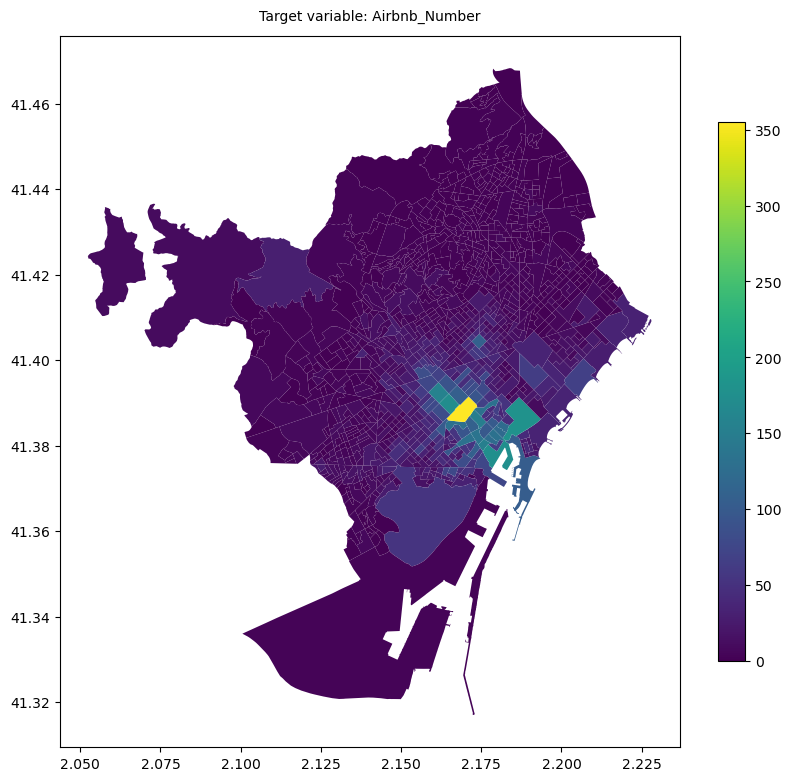

In [15]:
fig, ax = plt.subplots(figsize=(10, 10))

geo_info.plot(
    ax=ax,
    column=VARIABLE_TO_PREDICT,
    legend=True,
    figsize=(20, 20),
    legend_kwds={"shrink": 0.7},
)

ax.set_title("Target variable: " + str(VARIABLE_TO_PREDICT), fontsize=10, y=1.01)

if SAVE_FIGS:
    plt.savefig(DIR_SVR / "target_variable.svg", format="svg")

plt.show()

This plot shows the geographical distribution of the number of Airbnbs in Barcelona. It can be seen that there is a high concentration in the city center, and that it is apparently reduced when increasing the distance. In addition, the regions with a lower number of Airbnbs show a low variability.

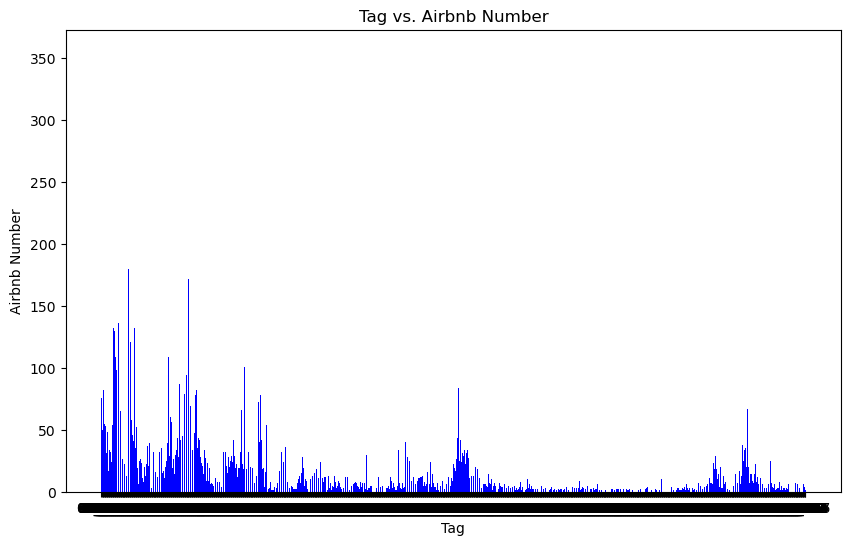

In [16]:
plt.figure(figsize=(10, 6))
plt.bar(geo_info.index, geo_info["Airbnb_Number"], color="b")
plt.xlabel("Tag")
plt.ylabel("Airbnb Number")
plt.title("Tag vs. Airbnb Number")
plt.show()

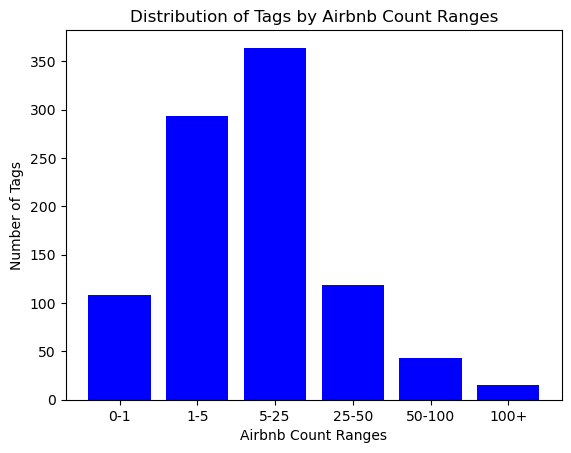

In [17]:
bins = [0, 1, 5, 25, 50, 100, 150]
labels = ["0-1", "1-5", "5-25", "25-50", "50-100", "100+"]

geo_info_rep = geo_info
geo_info_rep["Tag"] = geo_info_rep.index

geo_info_rep["Airbnb_Range"] = pd.cut(
    geo_info["Airbnb_Number"], bins=bins, labels=labels
)

tag_counts = geo_info.groupby("Airbnb_Range")["Tag"].count()

plt.bar(tag_counts.index, tag_counts.values, color="b")
plt.xlabel("Airbnb Count Ranges")
plt.ylabel("Number of Tags")
plt.title("Distribution of Tags by Airbnb Count Ranges")
plt.show()  # Display the plo

## NaNs

In [18]:
# define the colormap
cmap = plt.cm.Accent_r
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# force the first color entry to be grey
# cmaplist[0] = (0.5, 0.5, 0.5, 1.0)
cmaplist[0] = "0.8"
# define the bins and normalize
bounds = np.linspace(0, 8, 9)
my_norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

my_cmap = mpl.colors.LinearSegmentedColormap.from_list("Custom cmap", cmaplist, cmap.N)

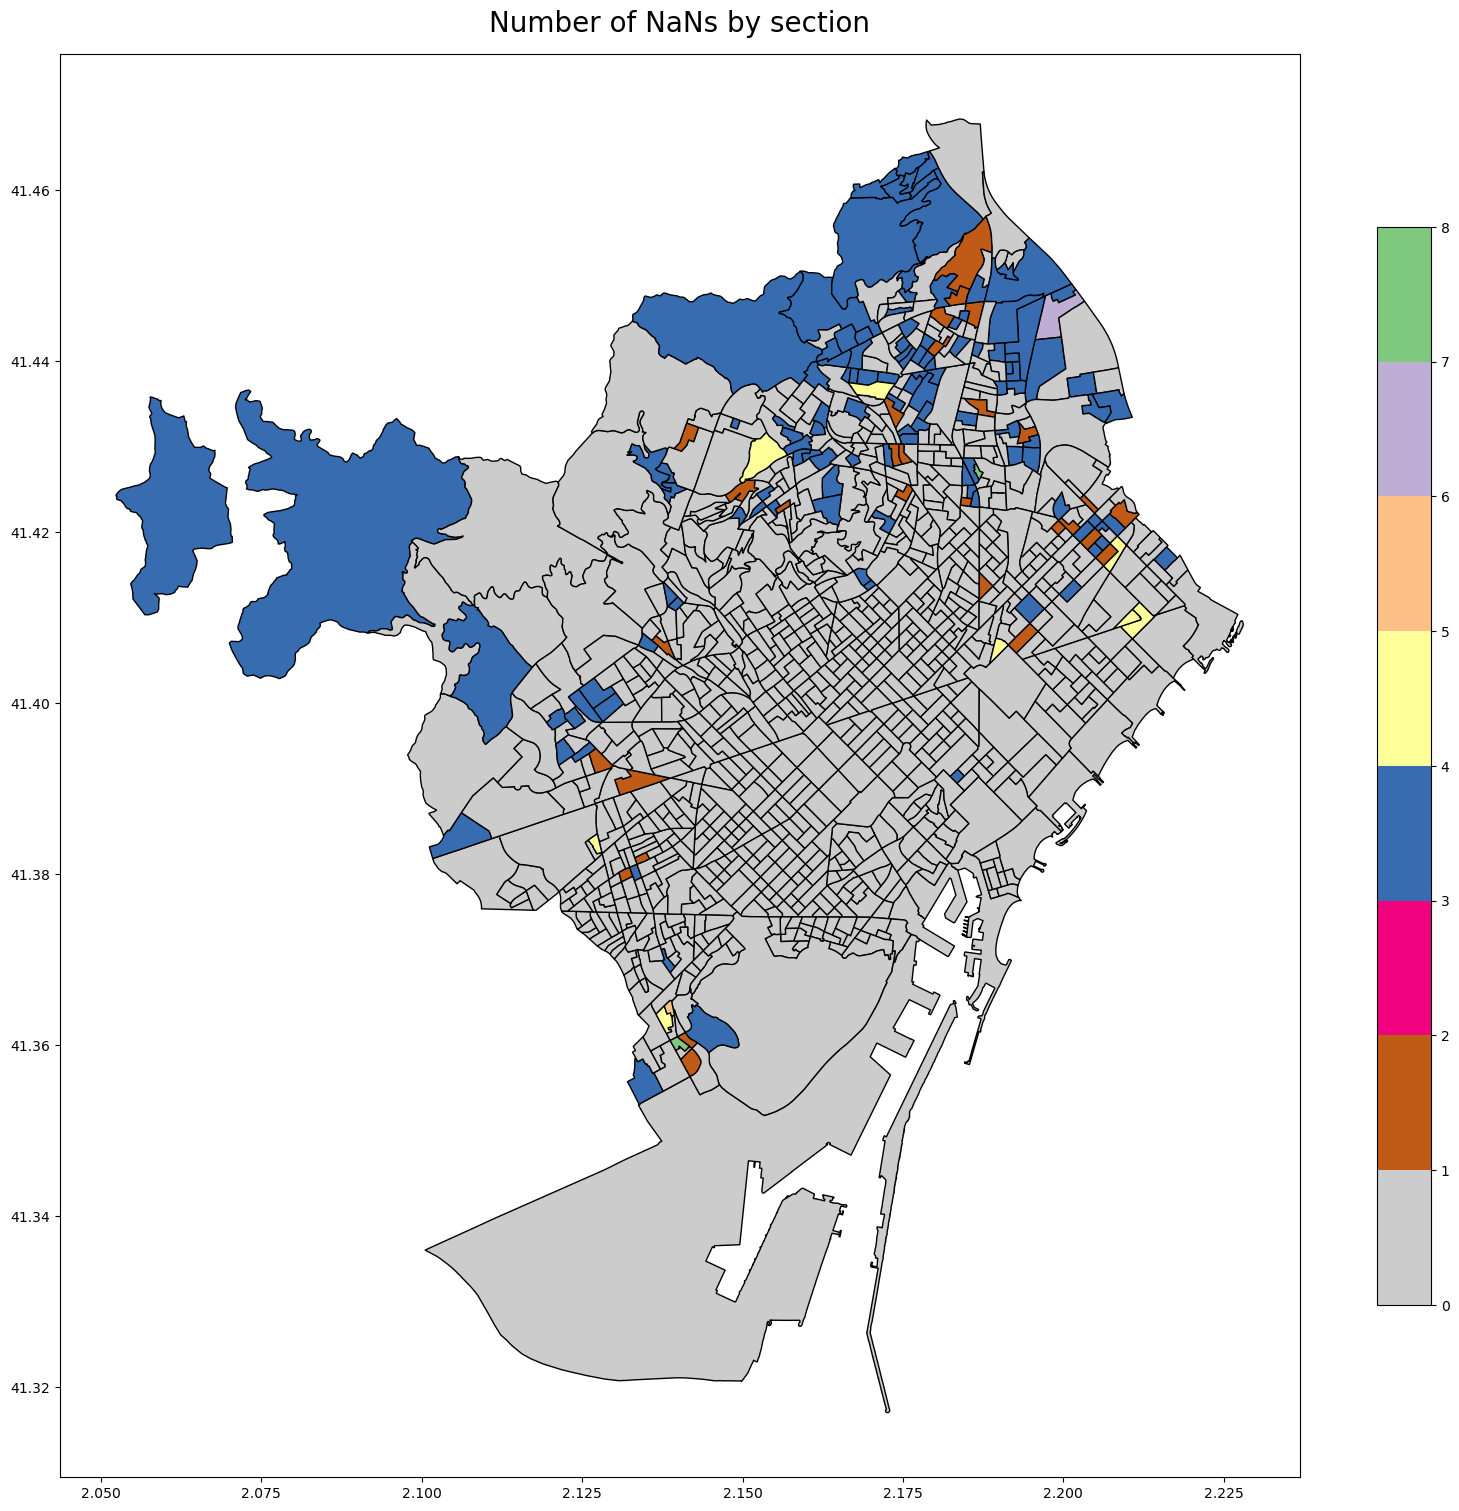

In [19]:
geo_nans["NaNs"] = pd.isnull(sect).sum(axis=1)

fig, ax = plt.subplots(figsize=(20, 20))

geo_nans.plot(
    ax=ax,
    column="NaNs",
    edgecolor="black",
    legend=True,
    norm=my_norm,
    cmap=my_cmap,
    figsize=(20, 20),
    legend_kwds={"shrink": 0.7},
)

ax.set_title("Number of NaNs by section", fontsize=20, y=1.01)

if SAVE_FIGS:
    plt.savefig(DIR_SVR / "nans.svg", format="svg")

plt.show()

## Support Vector Regression (SVR)

THIS EXPLANATION SHOULD INCLUDE KERNELS GIVEN THAT RBF IS USED

Support Vector Regression (SVR) uses the same principles as the SVM for classification, with only a few minor differences. Firstly, because we are dealing with regression instead of classification, the goal is to fit the error within a certain threshold.

### Objective Function

The SVR has a linear function defined as:

$$
f(x) = \mathbf{w}^T \mathbf{x} + b
$$

where $ \mathbf{w} $ represents the coefficient vector, $ \mathbf{x} $ is the feature vector, and $ b $ is the bias.

### Loss Function

The objective of SVR is to minimize the coefficient vector $ \mathbf{w} $, while keeping the errors within a certain margin $ \epsilon $. The model tries to ensure that the errors for each data point $ (x_i, y_i) $ are less than $ \epsilon $, but at the same time, it allows some flexibility by introducing slack variables $ \xi_i $ and $ \xi_i^* $. The optimization problem can be written as:

$$
\min_{\mathbf{w}, b, \xi, \xi^*} \frac{1}{2} \|\mathbf{w}\|^2 + C \sum_{i=1}^n (\xi_i + \xi_i^*)
$$

subject to:

$$
\begin{align*}
y_i - \mathbf{w}^T \mathbf{x}_i - b &\leq \epsilon + \xi_i \\
\mathbf{w}^T \mathbf{x}_i + b - y_i &\leq \epsilon + \xi_i^* \\
\xi_i, \xi_i^* &\geq 0
\end{align*}
$$

### Parameters:

- $ \mathbf{w} $, $ b $: Parameters of the regression model.
- $ \xi_i $, $ \xi_i^* $: Slack variables to allow some errors to be greater than $ \epsilon $.
- $ C $: Regularization parameter, which controls the trade-off between achieving a low error on the training data and minimizing the model complexity.
- $ \epsilon $: Specifies the epsilon-tube within which no penalty is associated in the training loss function with points predicted within a distance $ \epsilon $ from the actual values.

The parameter $ C $ serves as a regularization parameter in the SVR optimization formulation. A smaller $ C $ encourages a larger margin (hence more regularization), and a larger $ C $ encourages a smaller margin (hence less regularization, fitting tighter to the data). The $ \epsilon $ parameter defines the width of the tube which measures the deviation of the predictions from the actual data points allowed in the model.


# 1st model: all variables 
### Hyper-parameter Optimization ($\epsilon$ and $C$)
(Without kernel for the moment)

For the moment, all variables are selected. The purpose of this section is to have a first approach of the SVR model using different combinations of its hyper-parameters ($\epsilon$ and $C$) with all the variables. 

In [20]:
pd.isnull(X).sum(0)

Distance_Center            0
POI_Daily_Food             0
POI_Daily_Others           0
POI_House_Equipment        0
POI_Clothing               0
                          ..
Nationality_Oceania        0
Rent_Number_Flats         10
Rent_Price_Meter_Flats    18
Rent_Price_Total_Flats    18
Rent_Area_Flats           18
Length: 84, dtype: int64

Preprocessing Pipeline: 
- Imputation: KNNImputer fills in missing values to ensure the dataset is complete before further processing
- Power Transformation: it normalizes the distribution, reducing skewness and stabilizing variance
- Scaling: StandardScaler standardizes the data, ensuring it has zero mean and unit variance, contributing to consistent model training

In [21]:
imputer = KNNImputer()
# power transformation for stabilizing variance
power_transformer = PowerTransformer(method="yeo-johnson", standardize=True)
# scaling to standardize data (zero mean, unit variance)
scaler = StandardScaler()

pipeline = Pipeline(
    [
        ("imputer", imputer),
        ("power_transformer", power_transformer),
        ("scaler", scaler),
        ("svr", SVR(kernel="rbf")),
    ]
)

# HPO grid definition
Cl = 0
Ch = 10
param_grid = {
    "svr__C": [2**l for l in range(Cl, Ch + 1)],  # C in a range from Cl to Ch
    "svr__epsilon": [10**i for i in range(-5, 1)],  # epsilon from 0.1 to 1
}

print(param_grid)

# inner evaluation: 10-fold crossvalidation
folds = 3
kf = KFold(n_splits=folds, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    pipeline, param_grid, cv=kf, n_jobs=-1, scoring="neg_mean_squared_error"
)
grid_search.fit(X, y)

{'svr__C': [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024], 'svr__epsilon': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1]}


GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('imputer', KNNImputer()),
                                       ('power_transformer',
                                        PowerTransformer()),
                                       ('scaler', StandardScaler()),
                                       ('svr', SVR())]),
             n_jobs=-1,
             param_grid={'svr__C': [1, 2, 4, 8, 16, 32, 64, 128, 256, 512,
                                    1024],
                         'svr__epsilon': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1]},
             scoring='neg_mean_squared_error')

### Results plot

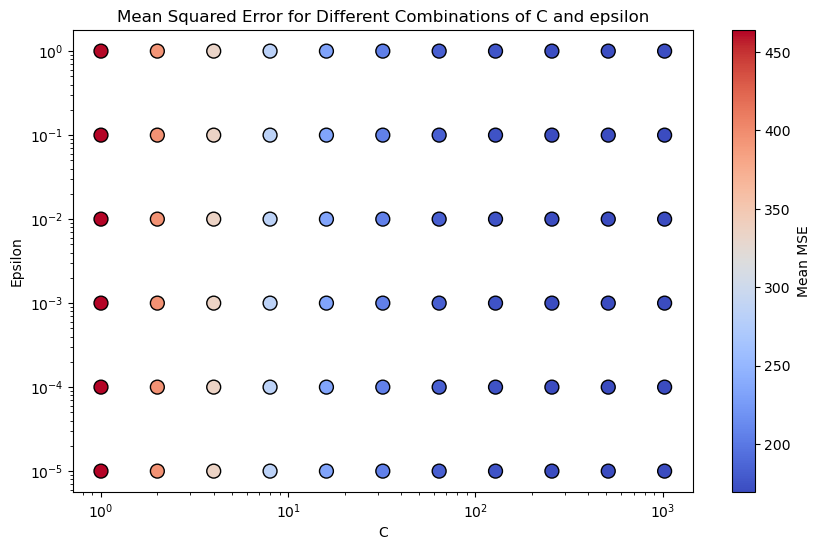

In [22]:
cv_results = grid_search.cv_results_  # MSE values from GridSearchCV results

# mean test MSE for each trial
mean_test_mse = cv_results["mean_test_score"]
mean_test_mse = -1 * mean_test_mse

# parameters associated with each trial
param_C = [params["svr__C"] for params in cv_results["params"]]
param_epsilon = [params["svr__epsilon"] for params in cv_results["params"]]

# scatter plot of MSE values against C and epsilon
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    param_C, param_epsilon, c=mean_test_mse, cmap="coolwarm", s=100, edgecolors="k"
)
plt.colorbar(scatter, label="Mean MSE")  # Add a color bar to show MSE scale
plt.xlabel("C")
plt.ylabel("Epsilon")
plt.title("Mean Squared Error for Different Combinations of C and epsilon")

# Set the x-axis and y-axis to logarithmic scale if C and epsilon have a wide range
plt.xscale("log")
plt.yscale("log")

plt.show()

In [23]:
best_params = grid_search.best_params_
best_model_1 = grid_search.best_estimator_

print("Best parameters:", best_params)

Best parameters: {'svr__C': 512, 'svr__epsilon': 1e-05}


In [24]:
svr_model_1 = best_model_1.named_steps["svr"]

intercept = svr_model_1.intercept_
support_vectors = svr_model_1.support_vectors_
dual_coefficients = svr_model_1.dual_coef_
support_indices = svr_model_1.support_

print("Intercept:", intercept)  # bias term, representing the offset from the origin
# print("Support Vectors:", support_vectors)  # indices of the support vectors in the training set
# print("Dual Coefficients:", dual_coefficients)     #support vectors used by the SVR model
# print("Support Indices:", support_indices)  # dual coefficients of the support vectors

# print(search_kbest.cv_results_)

Intercept: [19.32363107]


Understanding the output of the SVR model: 

- In this case, the input is a 1068 x 84 matrix. 

The result of an SVR model is a function of the following shape: $f(x)=w\cdot x + b$

- The intercept is $b$ in the equation, being the point at which the hyperplane intersects the y-axis in the feature space. 

- Support vectors are the data points from the boundary used to define the shape and position of the hyperplane. These have a very similar shape to the original matrix. 

### Model evaluation

In [25]:
y_truth = pd.Series(y, name="True Data")  # real y values

y_pred = best_model_1.predict(X)  # predicted values over the testing set
y_pred = pd.Series(
    y_pred, index=geo_info.index, name="SVR"
)  # relating the pred values with the geographical tags

#### Accuracy (Training) Representation

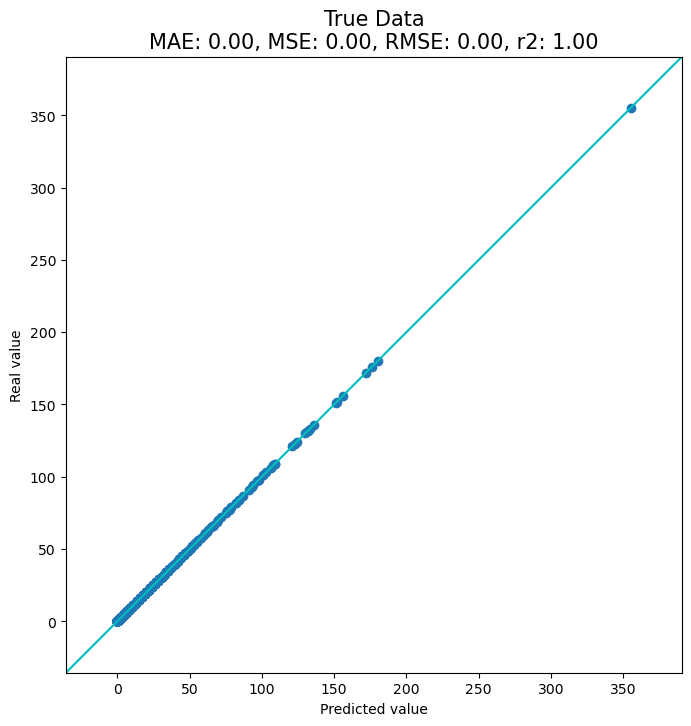

In [26]:
pa_svr = PredictedAccuracy(y_truth, y_pred)
pa_svr.plot_scatter(save_fig=SAVE_FIGS, dim=[8, 8], root_name=DIR_SVR / "svr_model")

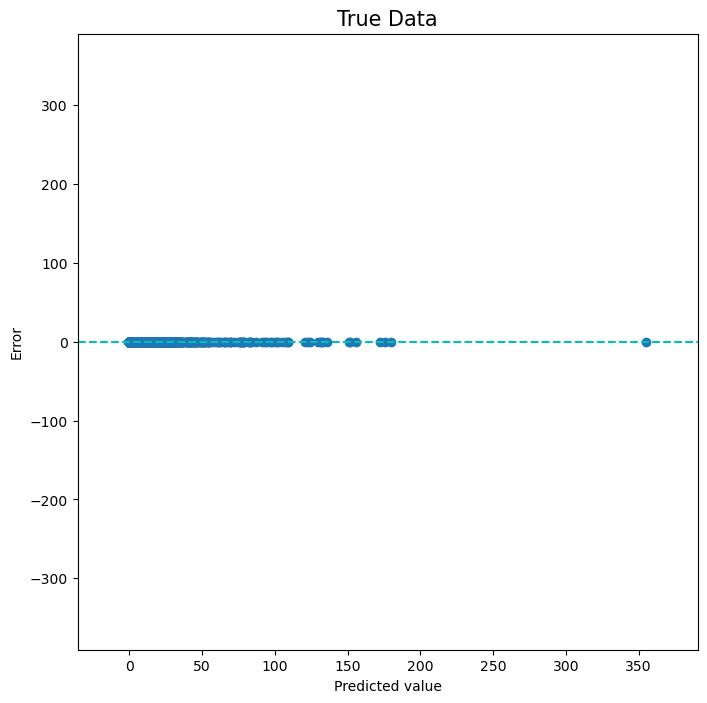

In [27]:
pa_svr.plot_errors(save_fig=SAVE_FIGS, dim=[8, 8], root_name=DIR_SVR / "svr_model")

#### Relative errors

In [28]:
# adding the error to the geographical information
geo_info["Chosen_Error"] = (
    2 * (y_truth.values - y_pred.values) / (abs(y_truth.values) + abs(y_pred.values))
)

col_lim = max(
    abs(geo_info["Chosen_Error"].min()), abs(geo_info["Chosen_Error"].max())
)  # maximum error value

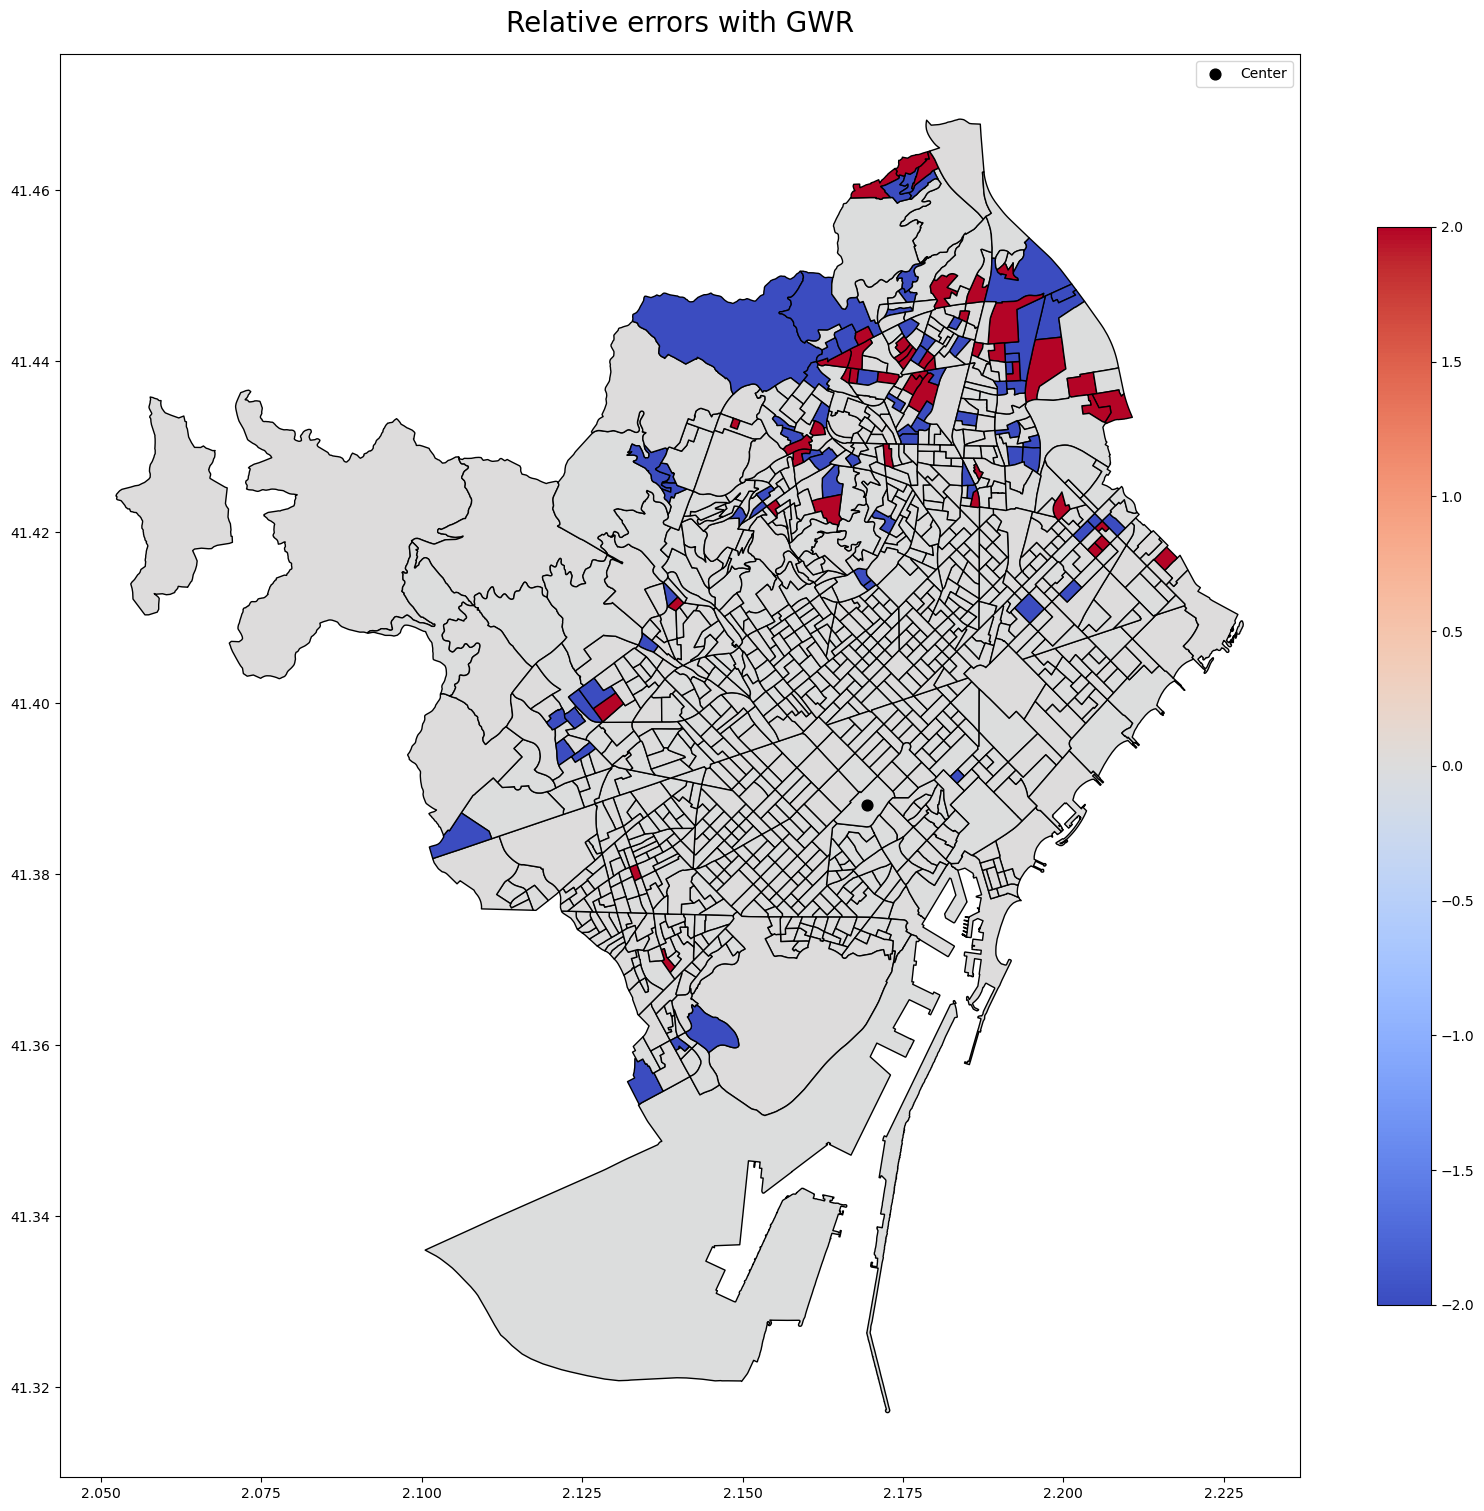

In [29]:
fig, ax = plt.subplots(figsize=(20, 20))
geo_info.plot(
    ax=ax,
    edgecolor="black",
    column="Chosen_Error",
    legend=True,
    vmin=-col_lim,
    vmax=col_lim,
    cmap="coolwarm",
    legend_kwds={"shrink": 0.7},
)

geo_info[geo_info.index == id_max_airbnb].centroid.plot(
    ax=ax, color="black", markersize=60, label="Center"
)

plt.legend()

ax.set_title("Relative errors with GWR", fontsize=20, y=1.01)

if SAVE_FIGS:
    plt.savefig(DIR_SVR / "relative_errors.svg", format="svg")

plt.show()

# 2nd Model: linear model variables 

A possibility is to use the best variables from the linear model: 

In [30]:
linear_coefs = pd.read_csv(DIR_MONTH / "01_linear/coefficients.csv", index_col=0)
best_model_linear = linear_coefs.drop(["Intercept"], axis=1).columns

print(best_model_linear)

Index(['Distance_Center', 'POI_Restaurants_Hotels', 'Nationality_Italy',
       'Nationality_UK', 'Percentage_Age_65_Plus', 'Percentage_Age_0_14'],
      dtype='object')


# 3rd Model: Feature Selection

In [31]:
feature_categories = {
    "Education": (X.filter(regex="^Education").columns.tolist(), K_EDUCATION),
    "Age": (X.filter(regex="^Percentage_Age_").columns.tolist(), K_AGE),
    "Nationality": (X.filter(regex="^Nationality_").columns.tolist(), K_NATIONALITY),
    "Rent": (X.filter(regex="^Rent_").columns.tolist(), K_RENT),
    "POI": (X.filter(regex="^POI").columns.tolist(), K_POI),
}

# pipeline for KNN Imputation and Scaling
imputer_scaler_pipeline = Pipeline(
    [
        ("imputer", KNNImputer()),
        ("scaler", StandardScaler()),
    ]
)

# pipelines for each category with SelectKBest
feature_selection_pipelines = []

for category, (features, k) in feature_categories.items():
    message = f"- {category} category --> {len(features)} variables (selecting {k}):"
    print(message)
    print(", ".join(features))
    feature_selector = Pipeline(
        [
            ("select", SelectKBest(score_func=f_regression, k=k)),  # SelectKBest
            ("scaler", StandardScaler()),  # Additional Scaling
        ]
    )
    feature_selection_pipelines.append((category, feature_selector))

# pipeline for those variables that are not 'categories'
non_category_pipeline = Pipeline(
    [
        ("select", SelectKBest(score_func=f_regression, k="all")),
        ("scaler", StandardScaler()),
    ]
)

# pipelines combination
feature_union = FeatureUnion(
    feature_selection_pipelines + [("NonCategory", non_category_pipeline)]
)

# main pipeline with SVR
main_pipeline = Pipeline(
    [
        ("imputation_scaling", imputer_scaler_pipeline),
        ("feature_selection", feature_union),
        ("scaler", StandardScaler()),
        ("svr", SVR()),
    ]
)
main_pipeline

- Education category --> 5 variables (selecting 1):
Education_None, Education_Primary_School, Education_Middle_School, Education_High_School, Education_University
- Age category --> 4 variables (selecting 2):
Percentage_Age_0_14, Percentage_Age_15_24, Percentage_Age_40_64, Percentage_Age_65_Plus
- Nationality category --> 50 variables (selecting 2):
Nationality_Spain, Nationality_Italy, Nationality_France, Nationality_UK, Nationality_Russia, Nationality_Germany, Nationality_Romania, Nationality_Portugal, Nationality_Ucrany, Nationality_Poland, Nationality_Netherlands, Nationality_Bulgaria, Nationality_Sweden, Nationality_Belgium, Nationality_Ireland, Nationality_Greece, Nationality_Switzerland, Nationality_Hungary, Nationality_Morocco, Nationality_Argelia, Nationality_Senegal, Nationality_Nigeria, Nationality_Colombia, Nationality_Honduras, Nationality_Venezuela, Nationality_Peru, Nationality_Argentina, Nationality_Bolivia, Nationality_Brazil, Nationality_Ecuador, Nationality_Dominican

Pipeline(steps=[('imputation_scaling',
                 Pipeline(steps=[('imputer', KNNImputer()),
                                 ('scaler', StandardScaler())])),
                ('feature_selection',
                 FeatureUnion(transformer_list=[('Education',
                                                 Pipeline(steps=[('select',
                                                                  SelectKBest(k=1,
                                                                              score_func=<function f_regression at 0x299b9f600>)),
                                                                 ('scaler',
                                                                  StandardScaler())])),
                                                ('Age',
                                                 Pipeline(steps=[('select',
                                                                  SelectKBest(k=2,
                                                                              scor...
                                                                              score_func=<function f_regression at 0x299b9f600>)),
                                                                 ('scaler',
                                                                  StandardScaler())])),
                                                ('POI',
                                                 Pipeline(steps=[('select',
                                                                  SelectKBest(score_func=<function f_regression at 0x299b9f600>)),
                                                                 ('scaler',
                                                                  StandardScaler())])),
                                                ('NonCategory',
                                                 Pipeline(steps=[('select',
                                                                  SelectKBest(k='all',
                                                                              score_func=<function f_regression at 0x299b9f600>)),
                                                                 ('scaler',
                                                                  StandardScaler())]))])),
                ('scaler', StandardScaler()), ('svr', SVR())])

In [32]:
# HPO grid definition
Cl = 0
Ch = 10
param_grid = {
    "svr__C": [2**l for l in range(Cl, Ch + 1)],  # C in a range from Cl to Ch
    "svr__epsilon": [10**i for i in range(-5, 1)],  # epsilon from 0.1 to 1
}

print(param_grid)

# inner evaluation: 10-fold crossvalidation
folds = 10
kf = KFold(n_splits=folds, shuffle=True, random_state=42)

# GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(
    main_pipeline, param_grid, cv=kf, n_jobs=-1, scoring="neg_mean_squared_error"
)
grid_search.fit(X, np.array(y))

# best parameters and model evaluation
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best parameters:", best_params)

{'svr__C': [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024], 'svr__epsilon': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1]}
Best parameters: {'svr__C': 256, 'svr__epsilon': 1}


## Feature Selection of Subgroups

Now, it is time to set the best parameters and perform the Feature Selection 

In [33]:
feature_categories = {
    "Education": ("^Education", K_EDUCATION),
    "Age": ("^Percentage_Age_", K_AGE),
    "Nationality": ("^Nationality_", K_NATIONALITY),
    "Rent": ("^Rent_", K_RENT),
    "POI": ("^POI", K_POI),
}

pt = PowerTransformer()
preprocessor = Pipeline(steps=[("imputer", KNNImputer()), ("pt", pt)])
selector = KBestSelector(
    score_func=f_regression, preprocessor=preprocessor, power_transformer=pt, y=y
)

X_transformed = X
chosen_features = {}
for cat, (regexp, n) in feature_categories.items():
    cat_features = X.filter(regex=regexp)
    chosen_features[cat] = selector.k_best_selection(
        features=cat_features, k=n
    )  # using KBest to select the best features of each category

    X_transformed.drop(
        np.setdiff1d(cat_features.columns, chosen_features[cat]), axis=1, inplace=True
    )  # dropping those features that are not the best

    print(f"{cat} selected features from {len(cat_features.columns)} originally:")
    print(chosen_features[cat])

print(X_transformed.shape)

Education selected features from 5 originally:
Index(['Education_University'], dtype='object')
Age selected features from 4 originally:
Index(['Percentage_Age_0_14', 'Percentage_Age_65_Plus'], dtype='object')
Nationality selected features from 50 originally:
Index(['Nationality_Italy', 'Nationality_UK'], dtype='object')
Rent selected features from 4 originally:
Index(['Rent_Number_Flats'], dtype='object')
POI selected features from 17 originally:
Index(['POI_Daily_Food', 'POI_Daily_Others', 'POI_House_Equipment',
       'POI_Clothing', 'POI_Culture', 'POI_Finances', 'POI_Restaurants_Hotels',
       'POI_Souvenirs_Thrift_Store', 'POI_Car_Parks', 'POI_Esthetics'],
      dtype='object')
(1068, 20)


## Feature Selection 

SVR Pipeline with the best parameters and Selected Features

In [34]:
svr_base = SVR(C=256, epsilon=0.95)  # SVR with RBF kernel

# Define the pipeline with RFE and SVR
SVR_pipeline = Pipeline(
    [
        ("imputer", KNNImputer()),  # Impute missing values
        ("scaler", StandardScaler()),  # Standardize features
        (
            "select_kbest",
            SelectKBest(score_func=f_regression),
        ),  # RFE with SVR as estimator
        ("svr", svr_base),  # SVR as the final regressor
    ]
)

param_grid = {"select_kbest__k": np.arange(1, 20, 1)}

search_kbest = GridSearchCV(
    SVR_pipeline, param_grid, scoring="neg_mean_squared_error", cv=5, n_jobs=-1
)

search_kbest.fit(X_transformed, y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('imputer', KNNImputer()),
                                       ('scaler', StandardScaler()),
                                       ('select_kbest',
                                        SelectKBest(score_func=<function f_regression at 0x299b9f600>)),
                                       ('svr', SVR(C=256, epsilon=0.95))]),
             n_jobs=-1,
             param_grid={'select_kbest__k': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19])},
             scoring='neg_mean_squared_error')

In [35]:
best_model = search_kbest.best_estimator_
svr_model = best_model.named_steps["svr"]

intercept = svr_model.intercept_
support_vectors = svr_model.support_vectors_
dual_coefficients = svr_model.dual_coef_
support_indices = svr_model.support_

print("Intercept:", intercept)  # bias term, representing the offset from the origin
# print("Support Vectors:", support_vectors)        #indices of the support vectors in the training set
# print("Dual Coefficients:", dual_coefficients)     #support vectors used by the SVR model
# print("Support Indices:", support_indices)  # dual coefficients of the support vectors

# print(search_kbest.cv_results_)

Intercept: [66.96186865]


Most Representative Features 

In [36]:
select_kbest = best_model.named_steps["select_kbest"]

selected_features_mask = (
    select_kbest.get_support()
)  # boolean array with the selected features
selected_features = X_transformed.columns[selected_features_mask]

print("Selected Features:", selected_features.tolist())

Selected Features: ['Distance_Center', 'POI_Restaurants_Hotels', 'Nationality_Italy', 'Nationality_UK']


Number of selected features vs. MSE

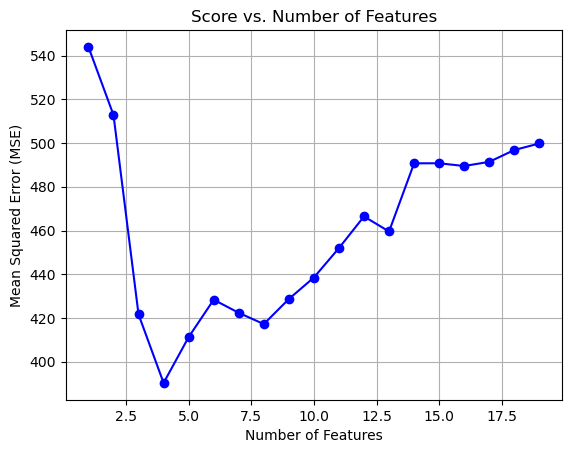

In [37]:
mean_test_score = -search_kbest.cv_results_["mean_test_score"]
k_values = search_kbest.cv_results_["param_select_kbest__k"].data

plt.plot(k_values, mean_test_score, marker="o", linestyle="-", color="b")
plt.xlabel("Number of Features")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("Score vs. Number of Features")
plt.grid(True)
plt.show()

### Model evaluation

In [38]:
y_truth = pd.Series(y, name="True Data")  # real y values:

y_pred = best_model.predict(X_transformed)  # predicted values over the testing set
y_pred = pd.Series(
    y_pred, index=geo_info.index, name="SVR"
)  # relating the pred values with the geographical tags

#### Accuracy (Training) Representation

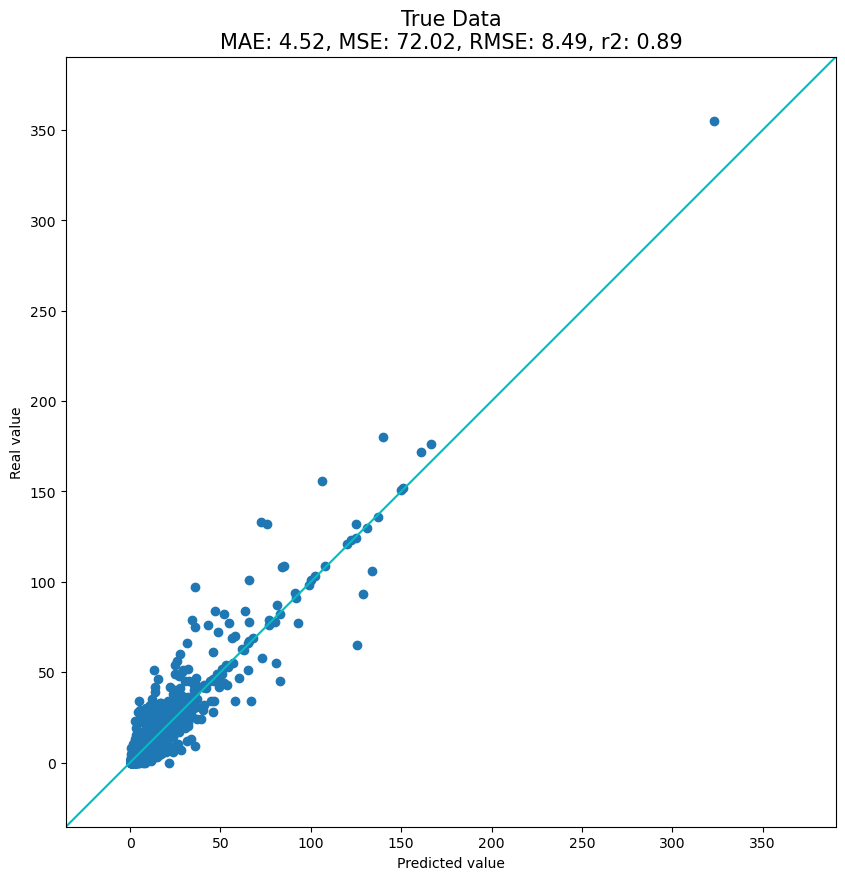

In [39]:
pa_svr = PredictedAccuracy(y_truth, y_pred)
pa_svr.plot_scatter(save_fig=SAVE_FIGS, root_name=DIR_SVR / "svr_model")

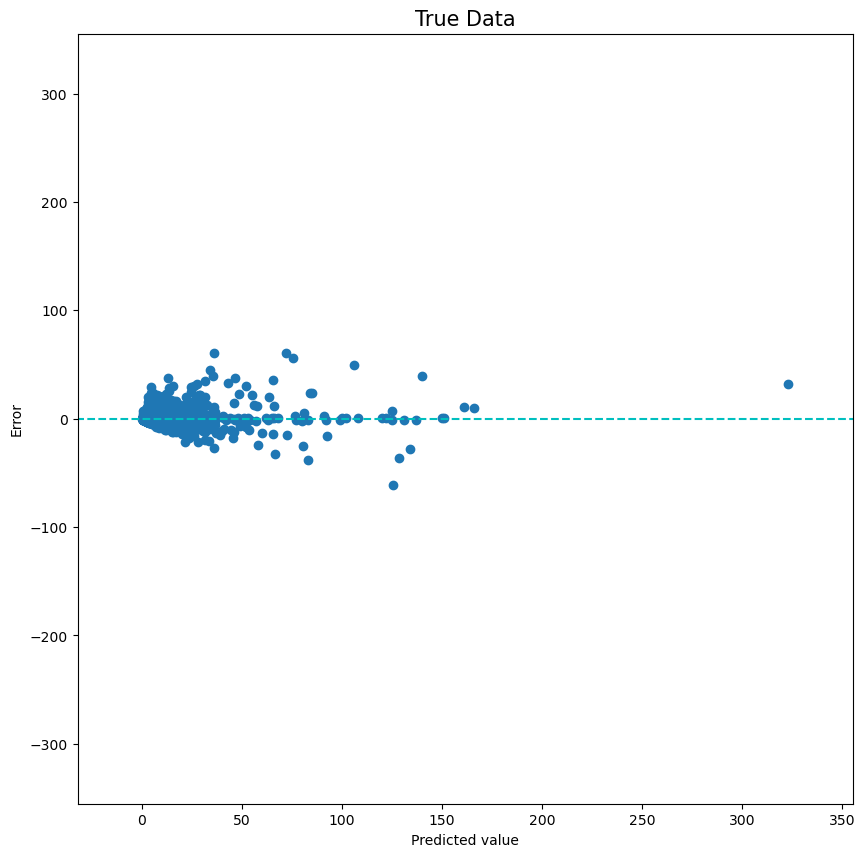

In [40]:
pa_svr.plot_errors(save_fig=SAVE_FIGS, root_name=DIR_SVR / "svr_model")

### Visual Representation

#### $R^2$

In the standard Support Vector Regression (SVR) model, there isn't an inherent concept of geography or spatial variation built into the model. 

SVR works with a feature-based approach, aiming to find a hyperplane that minimizes error within a defined margin, rather than considering spatial dependencies or variations.

In [41]:
# # adding to the geographical information the R2 metric
# geo_info["Chosen_Local_R2"] = gwr_results.localR2

# fig, ax = plt.subplots(figsize=(20, 20))
# geo_info.plot(
#     ax=ax,
#     edgecolor="black",
#     column="Chosen_Local_R2",
#     legend=True,
#     vmin=0.5,
#     vmax=1,
#     cmap="tab20b",
#     legend_kwds={"shrink": 0.7},
# )
# geo_info[geo_info.index == id_max_airbnb].centroid.plot(
#     ax=ax, color="black", markersize=60, label="Center"
# )

# plt.legend()

# ax.set_title(
#     "Local R2 with KNN = {}".format(int(gwr_bw)),
#     fontsize=20,
# )

# if SAVE_FIGS:
#     plt.savefig(DIR_SVR / "local_r2.svg", format="svg")

# plt.show()

#### Relative errors

In [42]:
# adding the error to the geographical information
geo_info["Chosen_Error"] = (
    2 * (y_truth.values - y_pred.values) / (abs(y_truth.values) + abs(y_pred.values))
)

col_lim = max(
    abs(geo_info["Chosen_Error"].min()), abs(geo_info["Chosen_Error"].max())
)  # maximum error value

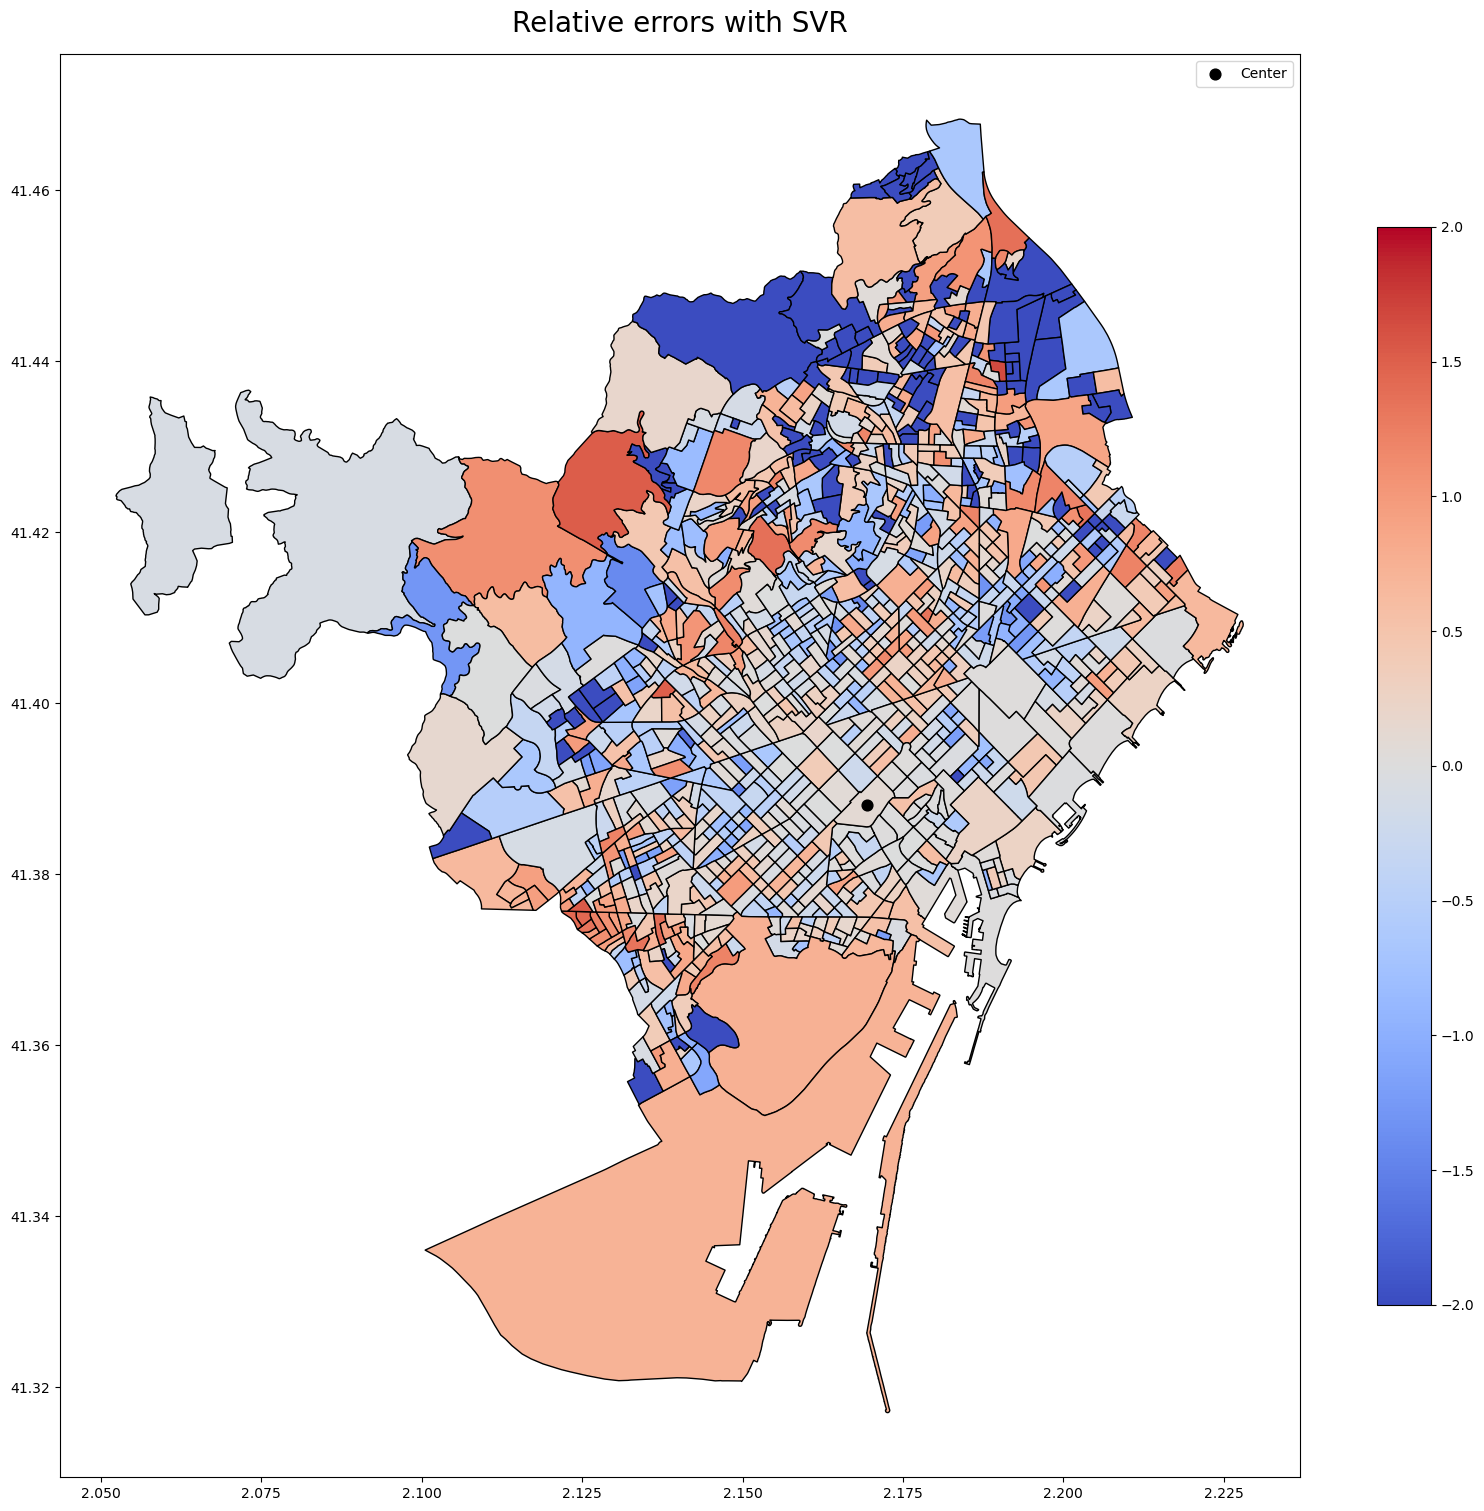

In [43]:
fig, ax = plt.subplots(figsize=(20, 20))
geo_info.plot(
    ax=ax,
    edgecolor="black",
    column="Chosen_Error",
    legend=True,
    vmin=-col_lim,
    vmax=col_lim,
    cmap="coolwarm",
    legend_kwds={"shrink": 0.7},
)

geo_info[geo_info.index == id_max_airbnb].centroid.plot(
    ax=ax, color="black", markersize=60, label="Center"
)

plt.legend()

ax.set_title("Relative errors with SVR", fontsize=20, y=1.01)

if SAVE_FIGS:
    plt.savefig(DIR_SVR / "relative_errors.svg", format="svg")

plt.show()